In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [51]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

#Imbalanced learn packages
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE #Synthetic Minority Oversampling Technique
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler

In [4]:
!pip install imbalanced-learn==0.6.0
!pip install scikit-learn==0.22.1


     |████████████████████████████████| 162 kB 3.5 MB/s eta 0:00:01


In [268]:
provider2 = pd.read_csv('provider2.csv')

In [269]:
provider2.columns

Index(['Unnamed: 0', 'Provider', 'PotentialFraud', 'patient_count',
       'patient_type', 'Race1', 'Race2', 'Race3', 'Race5', 'Male', 'Female',
       'mean_age', 'state_count', 'phy_count', 'no_phy', 'chronic_mean',
       'claim_count', 'days_admitted', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'coverage', 'totalamount_charged',
       'revenue_day', 'annual_amount', 'claimdiag', 'diag_grp', 'diag_4019',
       'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731',
       'diag_V5861', 'diag_2720', 'diag_2449', 'diag_4280', 'proc_4019',
       'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893',
       'proc_3995', 'proc_4516', 'proc_3722', 'proc_8151', 'duplicate_claims',
       'patient_duplicate_count'],
      dtype='object')

In [270]:
#tried to get get_dummies for patient_type
patient_type = pd.get_dummies(provider2['patient_type'], drop_first = True)

In [271]:
provider = pd.concat([provider2, patient_type], axis = 1).drop(['patient_type'], axis = 1)

In [272]:
#droping the months 
#provider = provider.drop(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
#                           axis = 1)


In [273]:
provider.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [274]:
provider["coverage"].fillna(provider["coverage"].mode()[0], inplace = True)

In [275]:
provider['PotentialFraud'] = [1 if x == 'Yes' else 0 for x in provider['PotentialFraud']]

In [276]:
provider.columns

Index(['Provider', 'PotentialFraud', 'patient_count', 'Race1', 'Race2',
       'Race3', 'Race5', 'Male', 'Female', 'mean_age', 'state_count',
       'phy_count', 'no_phy', 'chronic_mean', 'claim_count', 'days_admitted',
       'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'coverage',
       'totalamount_charged', 'revenue_day', 'annual_amount', 'claimdiag',
       'diag_grp', 'diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151', 'duplicate_claims', 'patient_duplicate_count', 'inpatient',
       'outpatient'],
      dtype='object')

In [277]:
provider.drop(['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt'], axis = 1, inplace = True)

In [278]:
#Confusion Matrix Plotting Function
def conf_mat(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.4%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax= plt.subplot()
    sns.heatmap(cm/np.sum(cm), annot=labels, ax = ax, fmt='', cmap='coolwarm');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Fraud', 'Potential Fraud']); ax.yaxis.set_ticklabels(['No Fraud', 'Potential Fraud'])
    return


In [279]:
x = provider.drop(['Provider','PotentialFraud'],axis=1)
y = provider['PotentialFraud']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(x), y, test_size=0.3, random_state=100)


In [208]:
#Undersampling via Edited Nearest Neighbors
en = EditedNearestNeighbours()
x_en, y_en = en.fit_resample(x, y)


In [209]:
x.columns

Index(['patient_count', 'Race1', 'Race2', 'Race3', 'Race5', 'Male', 'Female',
       'mean_age', 'state_count', 'phy_count', 'no_phy', 'chronic_mean',
       'claim_count', 'claimdiag', 'diag_grp', 'diag_4019', 'diag_25000',
       'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 'diag_V5861',
       'diag_2720', 'diag_2449', 'diag_4280', 'proc_4019', 'proc_9904',
       'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
       'proc_4516', 'proc_3722', 'proc_8151', 'patient_duplicate_count',
       'duplicate_claims', 'totalamount_charged', 'revenue_day',
       'annual_amount', 'coverage', 'inpatient', 'outpatient'],
      dtype='object')

## Logistic regression

### RIDGE

Accuracy Score: 0.8977202711028959
F1 Score: 0.5699481865284974
Recall Score: 0.7051282051282052
ROC-AUC Score: 0.8116643070630801


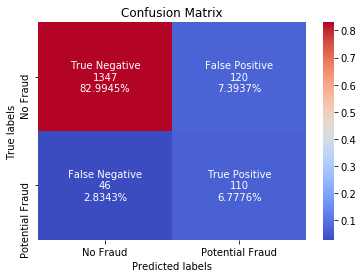

In [33]:
from sklearn.linear_model import LogisticRegressionCV

lg2 = LogisticRegressionCV(cv=10, random_state=100, class_weight='balanced', max_iter=2000)

lg2.fit(X_train,y_train)

y_pred = lg2.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print('Recall Score: {}'.format(recall_score(y_test, y_pred)))
print('ROC-AUC Score: {}'.format(roc_auc_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

In [210]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(StandardScaler().fit_transform(x_en), y_en, 
                                                                test_size=0.3, random_state=100)

Accuracy Score: 0.9484098939929329
F1 Score: 0.7114624505928855
Recall Score: 0.6293706293706294
ROC-AUC Score: 0.806823679465189


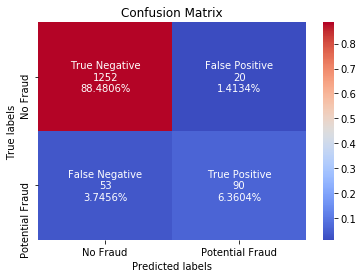

In [99]:
lg1 = LogisticRegressionCV(cv=5, random_state=100, max_iter=2000)

lg1.fit(X_train_en,y_train_en)

y_pred_en = lg1.predict(X_test_en)
# performance
print(f'Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [100]:
# Feature Importance for logistic regression(undersampling) top 15 features
pd.DataFrame(zip(x.columns, np.transpose(lg1.coef_.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(20)

,feature,coef
20,diag_grp,1.056947
27,diag_V5861,0.595042
19,claimdiag,0.575603
42,duplicate_claims,0.559527
44,revenue_day,0.450721
12,claim_count,0.432902
41,patient_duplicate_count,0.397245
28,diag_2720,0.356623
31,proc_4019,0.305073
24,diag_V5869,0.296044


In [39]:
pd.DataFrame(zip(x.columns, np.transpose(lg1.coef_.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).tail(15)

,feature,coef
21,diag_4019,-0.014011
7,mean_age,-0.015830
8,state_count,-0.020875
46,coverage,-0.022001
3,Race3,-0.029198
0,patient_count,-0.036766
1,Race1,-0.038225
16,IPAnnualDeductibleAmt,-0.043370
18,OPAnnualDeductibleAmt,-0.044267
2,Race2,-0.047854


### LASSO

Accuracy Score for Lasso: 0.9038817005545287
F1 Score for Lasso: 0.0
Recall Score for Lasso: 0.0
ROC-AUC Score for Lasso: 0.5


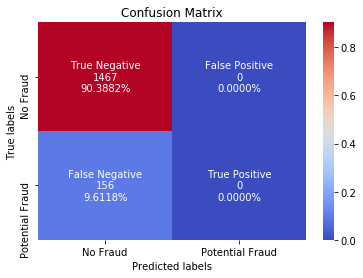

In [101]:
lg3 = LogisticRegressionCV(cv=5, random_state=100, class_weight='balanced', max_iter=2000, penalty='l1', 
                                   solver='liblinear')
lg3.fit(X_train,y_train)

y_pred = lg3.predict(X_test)
# performance
print(f'Accuracy Score for Lasso: {accuracy_score(y_test,y_pred)}')
print('F1 Score for Lasso: {}'.format(f1_score(y_test, y_pred)))
print('Recall Score for Lasso: {}'.format(recall_score(y_test, y_pred)))
print('ROC-AUC Score for Lasso: {}'.format(roc_auc_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

Accuracy Score: 0.9498233215547703
F1 Score: 0.714859437751004
Recall Score: 0.6223776223776224
ROC-AUC Score: 0.8045064212517044


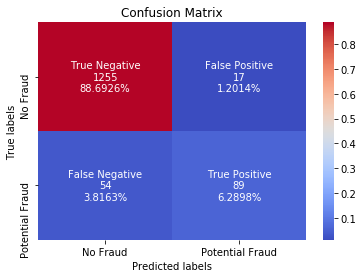

In [104]:
lg4 = LogisticRegressionCV(cv=5, random_state=100, max_iter=2000, penalty='l1', 
                                   solver='liblinear')

lg4.fit(X_train_en,y_train_en)

y_pred_en = lg4.predict(X_test_en)
# performance
print(f'Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [103]:
# Feature Importance for logistic regression(undersampling) top 15 features
pd.DataFrame(zip(x.columns, np.transpose(lg4.coef_.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
12,claim_count,2.010355
20,diag_grp,1.897309
42,duplicate_claims,1.841585
27,diag_V5861,0.727709
5,Male,0.599479
44,revenue_day,0.512702
41,patient_duplicate_count,0.396333
24,diag_V5869,0.344493
31,proc_4019,0.314114
19,claimdiag,0.291808


In [122]:
pd.DataFrame(zip(x.columns, np.transpose(lg4.coef_.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).tail(20)

,feature,coef
3,Race3,0.000000
5,Male,0.000000
6,Female,0.000000
7,mean_age,0.000000
1,Race1,0.000000
14,DeductibleAmtPaid,0.000000
12,claim_count,0.000000
18,OPAnnualDeductibleAmt,0.000000
21,diag_4019,0.000000
22,diag_25000,0.000000


In [80]:
lasso = pd.DataFrame(zip(x.columns, np.transpose(lg4.coef_.tolist()[0])), columns=['feature_lasso', 'coef_lasso'])\
            .sort_values('coef_lasso', ascending=False).head(15)

## SUPPORT VECTOR CLASSIFIER

Accuracy Score for SVC: 0.8743068391866913
F1 Score for SVC: 0.5486725663716814
Recall Score for SVC: 0.7948717948717948
ROC-AUC Score for SVC: 0.8388128572177651


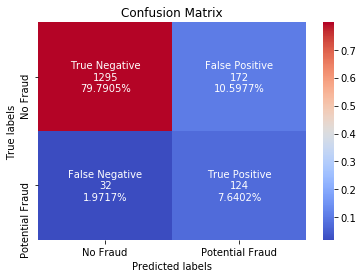

In [53]:
#SVM
svm= SVC(class_weight='balanced', random_state=100)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(f'Accuracy Score for SVC: {accuracy_score(y_test,y_pred)}')
print('F1 Score for SVC: {}'.format(f1_score(y_test, y_pred)))
print('Recall Score for SVC: {}'.format(recall_score(y_test, y_pred)))
print('ROC-AUC Score for SVC: {}'.format(roc_auc_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

Accuracy Score: 0.9469964664310954
F1 Score: 0.6987951807228916
Recall Score: 0.6083916083916084
ROC-AUC Score: 0.7967272507366847


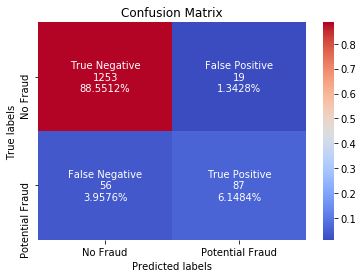

In [54]:
svm2= SVC(random_state=100)

svm2.fit(X_train_en,y_train_en)

y_pred_en = svm2.predict(X_test_en)
# performance
print(f'Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

Random Forest Accuracy Score: 0.9309919901417129
Random Forest F1 Score: 0.5447154471544715
Recall Score for Random Forest: 0.42948717948717946
ROC-AUC Score for Random Forest: 0.7069044622725604


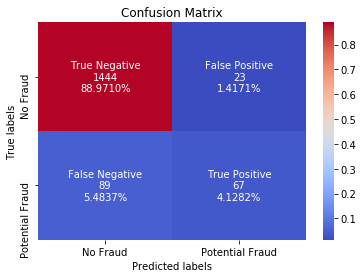

In [55]:
rF = ensemble.RandomForestClassifier(class_weight='balanced')
rF.fit(X_train, y_train)
y_pred = rF.predict(X_test)
print(f'Random Forest Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('Random Forest F1 Score: {}'.format(f1_score(y_test, y_pred)))
print('Recall Score for Random Forest: {}'.format(recall_score(y_test, y_pred)))
print('ROC-AUC Score for Random Forest: {}'.format(roc_auc_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

Random Forest Accuracy Score: 0.9540636042402827
Random Forest F1 Score: 0.749034749034749
Recall Score for Random Forest: 0.6783216783216783
ROC-AUC Score for Random Forest: 0.8316922857017197


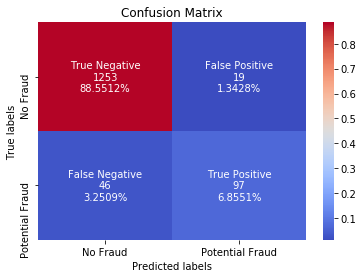

In [93]:
rF2 = ensemble.RandomForestClassifier()
rF2.fit(X_train_en, y_train_en)
y_pred_en = rF2.predict(X_test_en)
print(f'Random Forest Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('Random Forest F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score for Random Forest: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score for Random Forest: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [94]:
#Feature selection by Random forest

pd.DataFrame(zip(x.columns, list(rF2.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
20,diag_grp,0.110242
19,claimdiag,0.064674
28,diag_2720,0.055359
36,proc_3893,0.054490
27,diag_V5861,0.037012
43,totalamount_charged,0.034309
31,proc_4019,0.033289
13,InscClaimAmtReimbursed,0.032835
44,revenue_day,0.027748
35,proc_66,0.027559


In [81]:
RF = pd.DataFrame(zip(x.columns, list(rF2.feature_importances_)), columns=['feature_RF', 'coef_RF'])\
        .sort_values('coef_RF', ascending=False).head(15)

## XG Boost

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy Score: 0.9272951324707333
F1 Score: 0.549618320610687
Recall Score for XGBoost: 0.46153846153846156
ROC-AUC Score for XGBoost: 0.7191809553772744


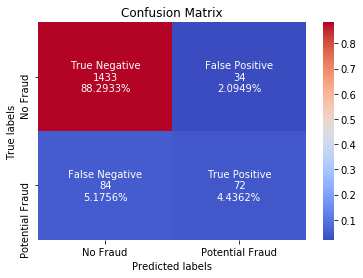

In [65]:
#XGB
xgb= XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f'XGBoost Accuracy Score: {accuracy_score(y_test,y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print('Recall Score for XGBoost: {}'.format(recall_score(y_test, y_pred)))
print('ROC-AUC Score for XGBoost: {}'.format(roc_auc_score(y_test, y_pred)))
conf_mat(y_test, y_pred)

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy Score: 0.9484098939929329
XGBoost F1 Score: 0.7265917602996255
Recall Score for XGBoost: 0.6783216783216783
ROC-AUC Score for XGBoost: 0.8285476316136693


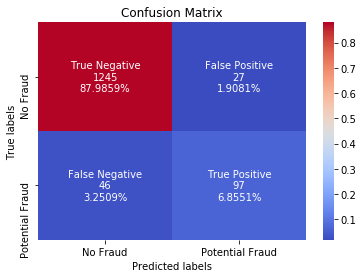

In [68]:
xgb2= XGBClassifier()
xgb2.fit(X_train_en, y_train_en)
y_pred_en = xgb2.predict(X_test_en)
print(f'XGBoost Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('XGBoost F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score for XGBoost: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score for XGBoost: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [69]:
pd.DataFrame(zip(x.columns, list(xgb2.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
20,diag_grp,0.369392
28,diag_2720,0.050401
27,diag_V5861,0.039613
42,duplicate_claims,0.039535
36,proc_3893,0.020485
43,totalamount_charged,0.019779
41,patient_duplicate_count,0.018588
26,diag_42731,0.018328
5,Male,0.018035
24,diag_V5869,0.017364


In [82]:
XGB = pd.DataFrame(zip(x.columns, list(xgb2.feature_importances_)), columns=['feature_XGB', 'coef_XGB'])\
            .sort_values('coef_XGB', ascending=False).head(15)

GaussianNB Accuracy Score: 0.9222614840989399
GaussianNB F1 Score: 0.6686746987951807
Recall Score for GaussianNB: 0.7762237762237763
ROC-AUC Score for GaussianNB: 0.8574515107533975


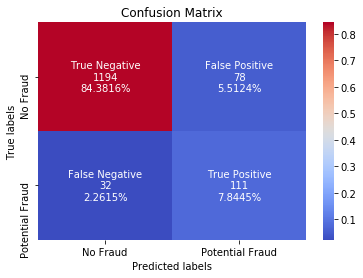

In [70]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_en, y_train_en)
y_pred_en = gnb.predict(X_test_en)
print(f'GaussianNB Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('GaussianNB F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score for GaussianNB: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score for GaussianNB: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [76]:
results = pd.DataFrame({'Model' : ['Ridge', 'Lasso', 'SVC', 'Random Forest', 'XGBoost', 'Naive Bayes'],
                         'Accuracy' : [0.95,0.94, 0.94, 0.94, 0.94, 0.92],
                         'F1' : [0.71, 0.71, 0.69, 0.71, 0.72, 0.60],
                         'Recall' : [0.62, 0.62, 0.60, 0.62, 0.67, 0.77], 
                         'ROC-AUC' : [0.80, 0.80, 0.79, 0.80, 0.82, 0.85]})

In [78]:
results

,Model,Accuracy,F1,Recall,ROC-AUC
0,Ridge,0.95,0.71,0.62,0.80
1,Lasso,0.94,0.71,0.62,0.80
2,SVC,0.94,0.69,0.60,0.79
3,Random Forest,0.94,0.71,0.62,0.80
4,XGBoost,0.94,0.72,0.67,0.82
5,Naive Bayes,0.92,0.60,0.77,0.85


In [85]:
from sklearn.ensemble import GradientBoostingClassifier

Gradient Boost Accuracy Score: 0.9547703180212014
Gradient Boost F1 Score: 0.7611940298507462
Recall Score for Gradient Boost: 0.7132867132867133
ROC-AUC Score for Gradient Boost: 0.847602476140212


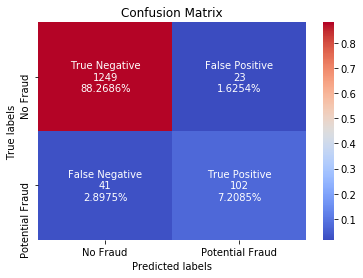

In [87]:
clf = GradientBoostingClassifier()
clf.fit(X_train_en, y_train_en)
y_pred_en = clf.predict(X_test_en)
print(f'Gradient Boost Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('Gradient Boost F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score for Gradient Boost: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score for Gradient Boost: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [91]:
pd.DataFrame(zip(x.columns, list(clf.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
20,diag_grp,0.620609
42,duplicate_claims,0.050214
28,diag_2720,0.042553
27,diag_V5861,0.032499
13,InscClaimAmtReimbursed,0.024337
15,IPAnnualReimbursementAmt,0.020614
24,diag_V5869,0.017445
44,revenue_day,0.015982
43,totalamount_charged,0.015149
22,diag_25000,0.014781


In [92]:
provider.to_csv('provider3.csv')

In [98]:
from sklearn.metrics import recall_score, precision_score, mean_squared_log_error, mean_squared_error,confusion_matrix,\
        roc_auc_score, f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, precision_recall_curve,\
        fbeta_score, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


In [252]:
def evaluate_model(X_train, X_test, y_train, y_test):
    classifiers = [LogisticRegression(penalty='l1', solver='liblinear'),
                   LinearSVC(),GaussianNB(),LinearDiscriminantAnalysis(),RandomForestClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    
    for classifier in classifiers:
    
        model = Pipeline(steps = [('classifier', classifier)])
    
        model.fit(X_train, y_train)
        
        predicted_train = model.predict(X_train)
        predicted_test = model.predict(X_test)
    
    
        print(type(classifier).__name__)
        #print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train, predicted_train)))
        print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, predicted_test)))
        #print('Recall Score for train data {:.3f}'.format(recall_score(y_train, predicted_train)))
        print('Recall Score for test data {:.3f}'.format(recall_score(y_test, predicted_test)))
        #print('fbeta0.2_score for train data{:.3f}'.format(fbeta_score(y_train, predicted_train, beta = 2)))
        print('fbeta0.2_score for test data{:.3f}'.format(fbeta_score(y_test, predicted_test, beta = 2)))
        #print('ROC-AUC Score for train data: {:.3f}'.format(roc_auc_score(y_train, predicted_train)))
        print('ROC-AUC Score for test data: {:.3f}'.format(roc_auc_score(y_test, predicted_test)))
        #print('Confusion matrix for train data')
        #print(confusion_matrix(y_train, predicted_train))
        print('Confusion matrix for test data')
        print(confusion_matrix(y_test, predicted_test))
        print('-' *50)


In [126]:
print(evaluate_model(X_train_en, X_test_en, y_train_en, y_test_en))

LogisticRegression
Accuracy Score for test data: 0.949
Recall Score for test data 0.636
fbeta0.2_score for test data0.666
ROC-AUC Score for test data: 0.810
Confusion matrix for test data
[[1252   20]
 [  52   91]]
--------------------------------------------------
LogisticRegressionCV
Accuracy Score for test data: 0.950
Recall Score for test data 0.622
fbeta0.2_score for test data0.656
ROC-AUC Score for test data: 0.805
Confusion matrix for test data
[[1255   17]
 [  54   89]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
Accuracy Score for test data: 0.951
Recall Score for test data 0.622
fbeta0.2_score for test data0.657
ROC-AUC Score for test data: 0.805
Confusion matrix for test data
[[1256   16]
 [  54   89]]
--------------------------------------------------
GaussianNB
Accuracy Score for test data: 0.922
Recall Score for test data 0.776
fbeta0.2_score for test data0.729
ROC-AUC Score for test data: 0.857
Confusion matrix for test data
[[1194   78]
 [  32  111]]
--------------------------------------------------
LinearDiscriminantAnalysis
Accuracy Score for test data: 0.945
Recall Score for test data 0.594
fbeta0.2_score for test data0.628
ROC-AUC Score for test data: 0.789
Confusion matrix for test data
[[1252   20]
 [  58   85]]
--------------------------------------------------
RandomForestClassifier
Accuracy Score for test data: 0.951
Recall Score for test data 0.657
fbeta0.2_score for test data0.685
ROC-AUC Score for test data: 0.821
Confusion matrix for test data
[[1252   20]
 [  49

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
Accuracy Score for test data: 0.948
Recall Score for test data 0.678
fbeta0.2_score for test data0.697
ROC-AUC Score for test data: 0.829
Confusion matrix for test data
[[1245   27]
 [  46   97]]
--------------------------------------------------
None


In [ ]:
print(evaluate_model(X_train_en, X_test_en, y_train_en, y_test_en))

In [131]:
lm = LogisticRegression()
lm.fit(X_train_en, y_train_en)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
coefs_lasso = abs(lm.coef_)
lasso_top15_features = pd.DataFrame(zip(x.columns, np.transpose(coefs_lasso.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

In [134]:
RF = RandomForestClassifier()
RF.fit(X_train_en, y_train_en)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [144]:
RF_top15_features = pd.DataFrame(zip(x.columns, list(RF.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

In [138]:
clf = GradientBoostingClassifier()
clf.fit(X_train_en, y_train_en)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [145]:
GradBoo_top15_features = pd.DataFrame(zip(x.columns, list(clf.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

In [149]:
xgb = XGBClassifier()
xgb.fit(X_train_en, y_train_en)

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [150]:
XGB_top15_features = pd.DataFrame(zip(x.columns, list(xgb.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

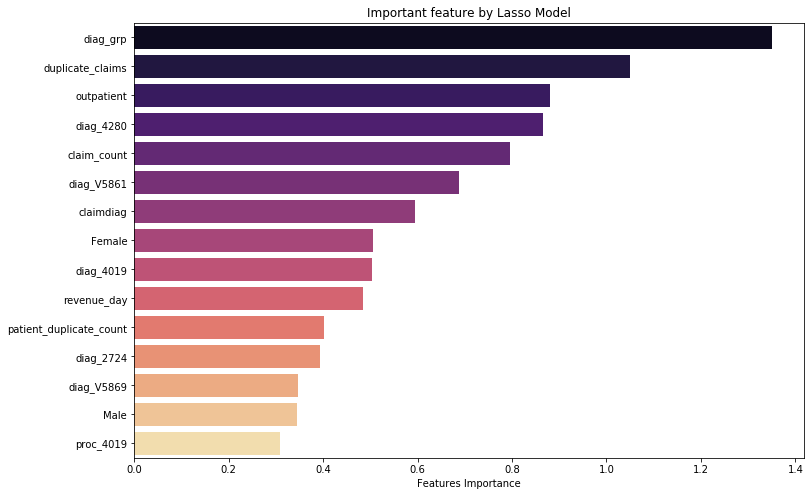

In [156]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=lasso_top15_features,palette="magma" )
ax.set_title('Important feature by Lasso Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

Text(0, 0.5, '')

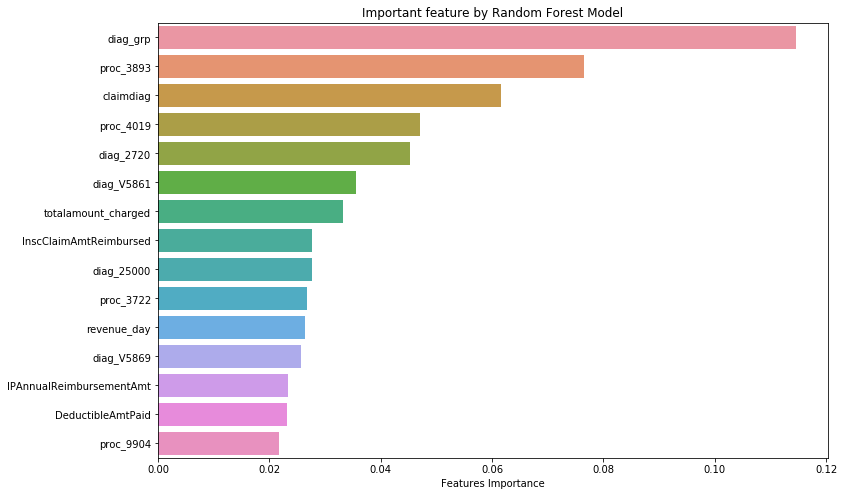

In [154]:
ax = sns.barplot(x="coef", y="feature", data=RF_top15_features)
ax.set_title('Important feature by Random Forest Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

Text(0, 0.5, '')

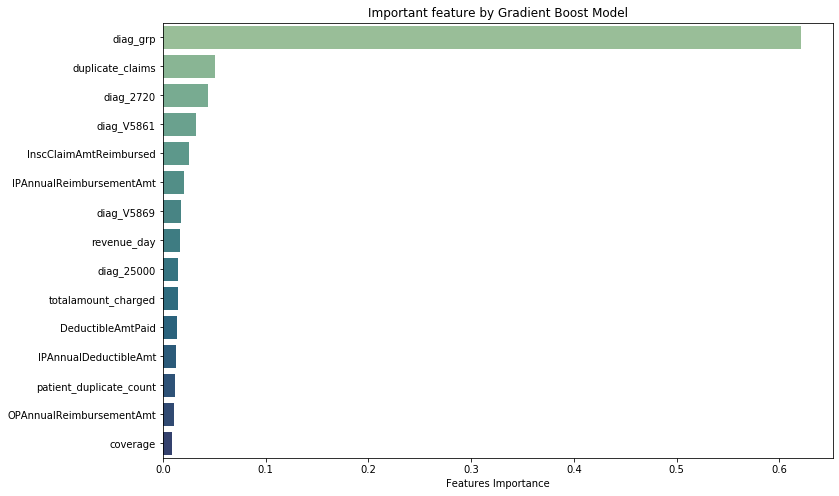

In [147]:

ax = sns.barplot(x="coef", y="feature", data=GradBoo_top15_features ,palette="crest" )
ax.set_title('Important feature by Gradient Boost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

Text(0, 0.5, '')

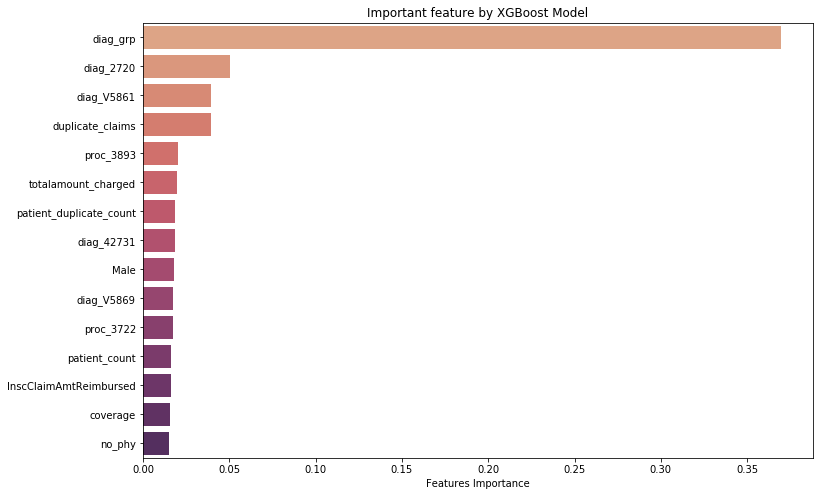

In [153]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=XGB_top15_features,palette="flare" )
ax.set_title('Important feature by XGBoost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [ ]:
selected_feature = lasso_selectedFeatures['Feature'].to_list()
X_train_selFeat = X_train1[selected_feature]
X_test_selFeat = X_test[selected_feature]

## Stratified Grid search 

In [177]:
def evaluate_model_stratified(X_train, X_test, y_train, y_test):
    classifiers = [LogisticRegression(penalty='l1', solver='liblinear'),LogisticRegressionCV(cv = 5, penalty='l1',solver='liblinear'),
                   LinearSVC(),GaussianNB(),LinearDiscriminantAnalysis(),RandomForestClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    
    for classifier in classifiers:
        kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state= 1)
        model = Pipeline(steps = [('classifier', classifier)])
        str_cv= GridSearchCV(estimator= model, scoring='recall', cv=kfold, param_grid = {})
        str_cv.fit(X_train, y_train)
    
        
        
        predicted_train = str_cv.predict(X_train)
        predicted_test = str_cv.predict(X_test)
    
    
        print(type(classifier).__name__)
        #print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train, predicted_train)))
        print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, predicted_test)))
        #print('Recall Score for train data {:.3f}'.format(recall_score(y_train, predicted_train)))
        print('Recall Score for test data {:.3f}'.format(recall_score(y_test, predicted_test)))
        #print('fbeta0.2_score for train data{:.3f}'.format(fbeta_score(y_train, predicted_train, beta = 2)))
        print('fbeta0.2_score for test data{:.3f}'.format(fbeta_score(y_test, predicted_test, beta = 2)))
        #print('ROC-AUC Score for train data: {:.3f}'.format(roc_auc_score(y_train, predicted_train)))
        print('ROC-AUC Score for test data: {:.3f}'.format(roc_auc_score(y_test, predicted_test)))
        #print('Confusion matrix for train data')
        #print(confusion_matrix(y_train, predicted_train))
        print('Confusion matrix for test data')
        print(confusion_matrix(y_test, predicted_test))
        print('-' *50)


In [178]:
evaluate_model_stratified(X_train_en, X_test_en, y_train_en, y_test_en)

LogisticRegression
Accuracy Score for test data: 0.949
Recall Score for test data 0.636
fbeta0.2_score for test data0.666
ROC-AUC Score for test data: 0.810
Confusion matrix for test data
[[1252   20]
 [  52   91]]
--------------------------------------------------
LogisticRegressionCV
Accuracy Score for test data: 0.950
Recall Score for test data 0.622
fbeta0.2_score for test data0.656
ROC-AUC Score for test data: 0.805
Confusion matrix for test data
[[1255   17]
 [  54   89]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the num

LinearSVC
Accuracy Score for test data: 0.950
Recall Score for test data 0.615
fbeta0.2_score for test data0.651
ROC-AUC Score for test data: 0.801
Confusion matrix for test data
[[1256   16]
 [  55   88]]
--------------------------------------------------
GaussianNB
Accuracy Score for test data: 0.922
Recall Score for test data 0.776
fbeta0.2_score for test data0.729
ROC-AUC Score for test data: 0.857
Confusion matrix for test data
[[1194   78]
 [  32  111]]
--------------------------------------------------
LinearDiscriminantAnalysis
Accuracy Score for test data: 0.945
Recall Score for test data 0.594
fbeta0.2_score for test data0.628
ROC-AUC Score for test data: 0.789
Confusion matrix for test data
[[1252   20]
 [  58   85]]
--------------------------------------------------
RandomForestClassifier
Accuracy Score for test data: 0.952
Recall Score for test data 0.664
fbeta0.2_score for test data0.691
ROC-AUC Score for test data: 0.824
Confusion matrix for test data
[[1252   20]
 [  48

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

## fifth iteration

In [211]:
print(evaluate_model(X_train_en, X_test_en, y_train_en, y_test_en))

LogisticRegression
Accuracy Score for test data: 0.942
Recall Score for test data 0.648
fbeta0.2_score for test data0.665
ROC-AUC Score for test data: 0.811
Confusion matrix for test data
[[1246   32]
 [  50   92]]
--------------------------------------------------
LogisticRegressionCV
Accuracy Score for test data: 0.943
Recall Score for test data 0.662
fbeta0.2_score for test data0.676
ROC-AUC Score for test data: 0.818
Confusion matrix for test data
[[1245   33]
 [  48   94]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
Accuracy Score for test data: 0.946
Recall Score for test data 0.641
fbeta0.2_score for test data0.664
ROC-AUC Score for test data: 0.810
Confusion matrix for test data
[[1252   26]
 [  51   91]]
--------------------------------------------------
GaussianNB
Accuracy Score for test data: 0.911
Recall Score for test data 0.739
fbeta0.2_score for test data0.689
ROC-AUC Score for test data: 0.835
Confusion matrix for test data
[[1189   89]
 [  37  105]]
--------------------------------------------------
LinearDiscriminantAnalysis
Accuracy Score for test data: 0.942
Recall Score for test data 0.613
fbeta0.2_score for test data0.638
ROC-AUC Score for test data: 0.796
Confusion matrix for test data
[[1251   27]
 [  55   87]]
--------------------------------------------------
RandomForestClassifier
Accuracy Score for test data: 0.944
Recall Score for test data 0.648
fbeta0.2_score for test data0.668
ROC-AUC Score for test data: 0.813
Confusion matrix for test data
[[1249   29]
 [  50

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
Accuracy Score for test data: 0.937
Recall Score for test data 0.648
fbeta0.2_score for test data0.657
ROC-AUC Score for test data: 0.808
Confusion matrix for test data
[[1238   40]
 [  50   92]]
--------------------------------------------------
None


In [187]:
provider.columns

Index(['Provider', 'PotentialFraud', 'patient_count', 'Race1', 'Race2',
       'Race3', 'Race5', 'Male', 'Female', 'mean_age', 'state_count',
       'phy_count', 'no_phy', 'chronic_mean', 'claim_count',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'claimdiag',
       'diag_grp', 'diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151', 'patient_duplicate_count', 'duplicate_claims',
       'totalamount_charged', 'revenue_day', 'annual_amount', 'coverage',
       'inpatient', 'outpatient'],
      dtype='object')

In [212]:
lm = LogisticRegression()
lm.fit(X_train_en, y_train_en)
coefs_lasso = abs(lm.coef_)
lasso_top15_features = pd.DataFrame(zip(x.columns, np.transpose(coefs_lasso.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

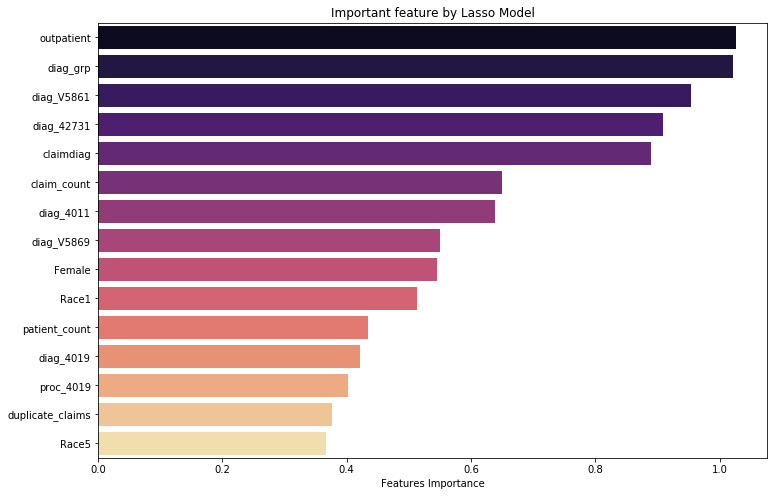

In [213]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=lasso_top15_features,palette="magma" )
ax.set_title('Important feature by Lasso Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [214]:
RF = RandomForestClassifier()
RF.fit(X_train_en, y_train_en)
RF_top15_features = pd.DataFrame(zip(x.columns, list(RF.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

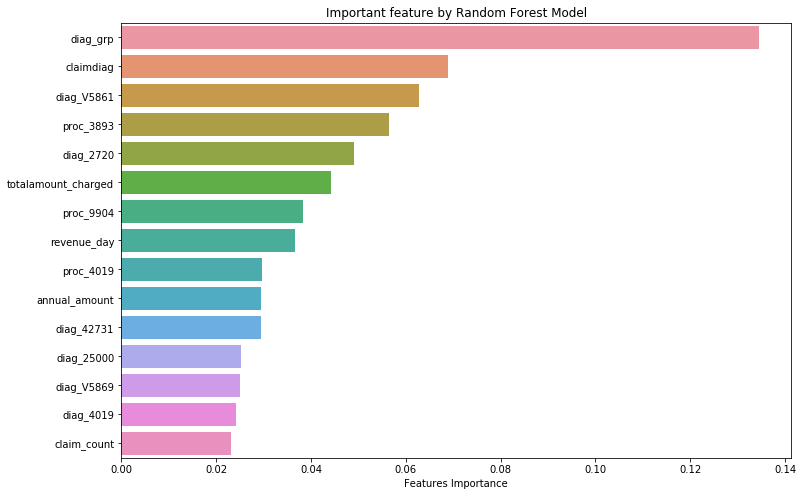

In [215]:
ax = sns.barplot(x="coef", y="feature", data=RF_top15_features)
ax.set_title('Important feature by Random Forest Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [216]:
clf = GradientBoostingClassifier()
clf.fit(X_train_en, y_train_en)
GradBoo_top15_features = pd.DataFrame(zip(x.columns, list(clf.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

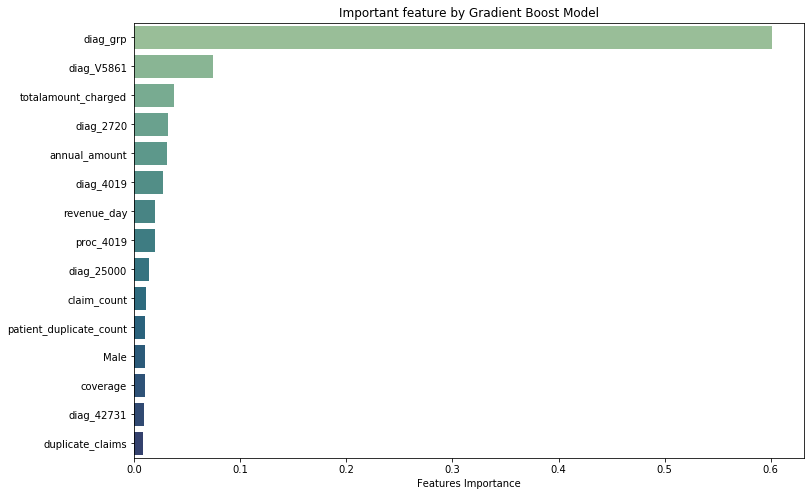

In [217]:

ax = sns.barplot(x="coef", y="feature", data=GradBoo_top15_features ,palette="crest" )
ax.set_title('Important feature by Gradient Boost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [218]:
xgb = XGBClassifier()
xgb.fit(X_train_en, y_train_en)
XGB_top15_features = pd.DataFrame(zip(x.columns, list(xgb.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0, 0.5, '')

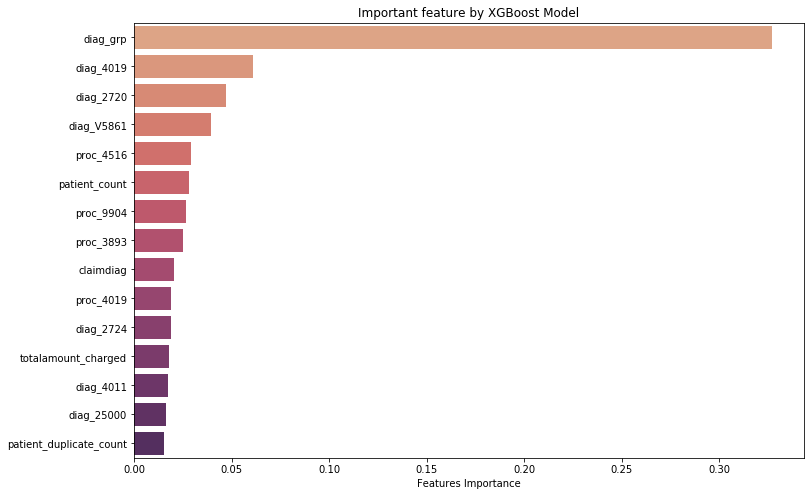

In [219]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=XGB_top15_features,palette="flare" )
ax.set_title('Important feature by XGBoost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [220]:
provider.columns

Index(['Provider', 'PotentialFraud', 'patient_count', 'Race1', 'Race2',
       'Race3', 'Race5', 'Male', 'Female', 'mean_age', 'state_count',
       'phy_count', 'no_phy', 'chronic_mean', 'claim_count', 'claimdiag',
       'diag_grp', 'diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151', 'patient_duplicate_count', 'duplicate_claims',
       'totalamount_charged', 'revenue_day', 'annual_amount', 'coverage',
       'inpatient', 'outpatient'],
      dtype='object')

In [280]:
provider4 = provider.drop(['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151'], axis = 1)

In [232]:
x4 = provider4.drop(['Provider','PotentialFraud'],axis=1)
y4 = provider4['PotentialFraud']
# train-test split
X_train4, X_test4, y_train4, y_test4 = train_test_split(StandardScaler().fit_transform(x4), y4, test_size=0.3, random_state=100)


In [239]:
x4.columns

Index(['patient_count', 'Race1', 'Race2', 'Race3', 'Race5', 'Male', 'Female',
       'mean_age', 'state_count', 'phy_count', 'no_phy', 'chronic_mean',
       'claim_count', 'claimdiag', 'diag_grp', 'patient_duplicate_count',
       'duplicate_claims', 'totalamount_charged', 'revenue_day',
       'annual_amount', 'coverage', 'inpatient', 'outpatient'],
      dtype='object')

In [233]:
en = EditedNearestNeighbours()
x_en4, y_en4 = en.fit_resample(x4, y4)

In [234]:
X_train_en4, X_test_en4, y_train_en4, y_test_en4 = train_test_split(StandardScaler().fit_transform(x_en4), y_en4, 
                                                                test_size=0.3, random_state=100)

In [253]:
print(evaluate_model(X_train_en4, X_test_en4, y_train_en4, y_test_en4))

LogisticRegression
Accuracy Score for test data: 0.955
Recall Score for test data 0.646
fbeta0.2_score for test data0.683
ROC-AUC Score for test data: 0.818
Confusion matrix for test data
[[1261   12]
 [  52   95]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
Accuracy Score for test data: 0.955
Recall Score for test data 0.619
fbeta0.2_score for test data0.662
ROC-AUC Score for test data: 0.806
Confusion matrix for test data
[[1265    8]
 [  56   91]]
--------------------------------------------------
GaussianNB
Accuracy Score for test data: 0.923
Recall Score for test data 0.633
fbeta0.2_score for test data0.632
ROC-AUC Score for test data: 0.795
Confusion matrix for test data
[[1218   55]
 [  54   93]]
--------------------------------------------------
LinearDiscriminantAnalysis
Accuracy Score for test data: 0.951
Recall Score for test data 0.605
fbeta0.2_score for test data0.647
ROC-AUC Score for test data: 0.798
Confusion matrix for test data
[[1262   11]
 [  58   89]]
--------------------------------------------------
RandomForestClassifier
Accuracy Score for test data: 0.956
Recall Score for test data 0.680
fbeta0.2_score for test data0.710
ROC-AUC Score for test data: 0.834
Confusion matrix for test data
[[1257   16]
 [  47

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
Accuracy Score for test data: 0.959
Recall Score for test data 0.748
fbeta0.2_score for test data0.765
ROC-AUC Score for test data: 0.866
Confusion matrix for test data
[[1252   21]
 [  37  110]]
--------------------------------------------------
None


In [240]:
lm = LogisticRegression()
lm.fit(X_train_en4, y_train_en4)
coefs_lasso = abs(lm.coef_)
lasso_top15_features = pd.DataFrame(zip(x4.columns, np.transpose(coefs_lasso.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

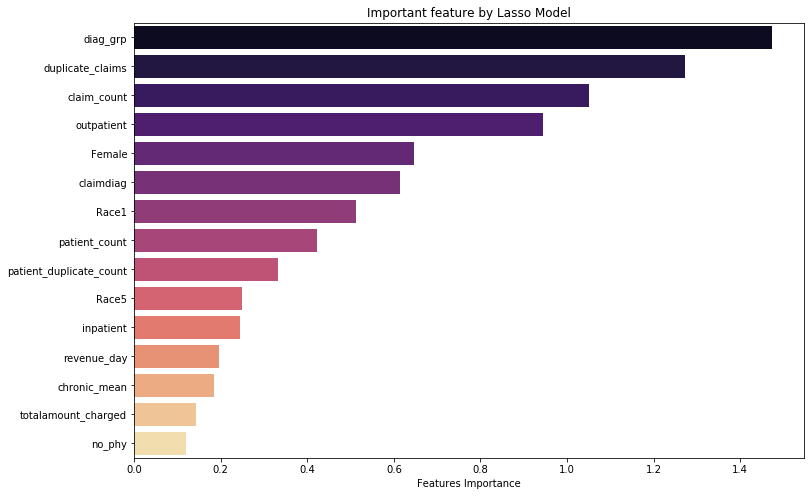

In [241]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=lasso_top15_features,palette="magma" )
ax.set_title('Important feature by Lasso Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [242]:
RF = RandomForestClassifier()
RF.fit(X_train_en4, y_train_en4)
RF_top15_features = pd.DataFrame(zip(x4.columns, list(RF.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

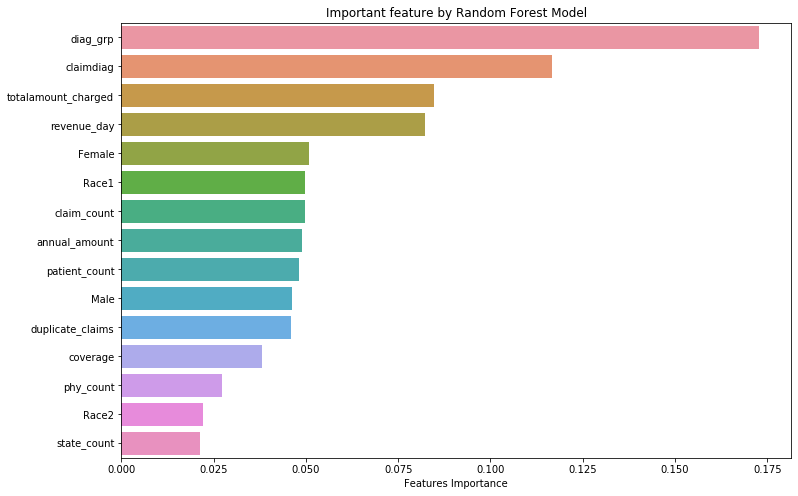

In [243]:
ax = sns.barplot(x="coef", y="feature", data=RF_top15_features)
ax.set_title('Important feature by Random Forest Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [245]:
clf = GradientBoostingClassifier()
clf.fit(X_train_en4, y_train_en4)
GradBoo_top15_features = pd.DataFrame(zip(x4.columns, list(clf.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

Text(0, 0.5, '')

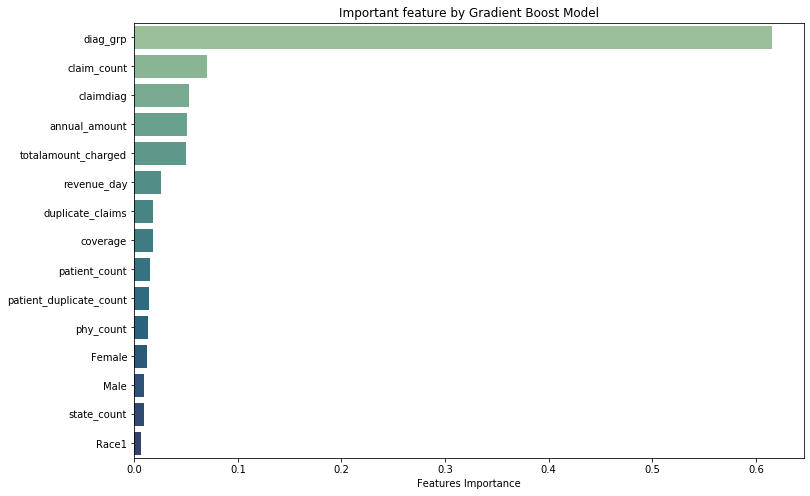

In [246]:
ax = sns.barplot(x="coef", y="feature", data=GradBoo_top15_features ,palette="crest" )
ax.set_title('Important feature by Gradient Boost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [249]:
xgb = XGBClassifier()
xgb.fit(X_train_en4, y_train_en4)
XGB_top15_features = pd.DataFrame(zip(x4.columns, list(xgb.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0, 0.5, '')

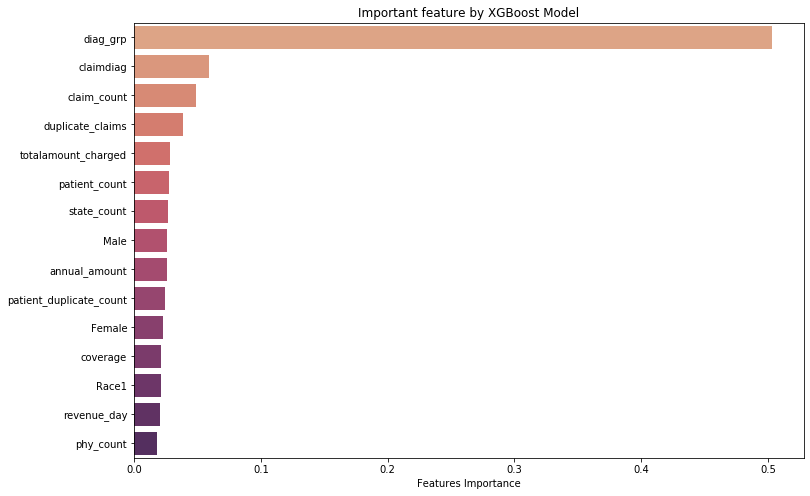

In [250]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=XGB_top15_features,palette="flare" )
ax.set_title('Important feature by XGBoost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [251]:
provider4.shape

(5410, 25)

In [254]:
results = pd.DataFrame({'Model' : ['Lasso', 'LinearSVC', 'GaussianNB', 'LinearDiscriminantAnalysis','Random Forest',\
                                   'GradientBoost','XGBoost'],
                         'Accuracy' : [0.955,0.955, 0.923, 0.951, 0.956, 0.954, 0.95],
                         'Recall' : [0.646, 0.619, 0.633, 0.605, 0.680, 0.735, 0.738],
                         'F2beta score' : [0.683, 0.662,0.632, 0.647, 0.710, 0.747, 0.765], 
                         'ROC-AUC' : [0.818, 0.806, 0.795, 0.798, 0.834, 0.857, 0.866]})

In [255]:
results

,Model,Accuracy,Recall,F2beta score,ROC-AUC
0,Lasso,0.955,0.646,0.683,0.818
1,LinearSVC,0.955,0.619,0.662,0.806
2,GaussianNB,0.923,0.633,0.632,0.795
3,LinearDiscriminantAnalysis,0.951,0.605,0.647,0.798
4,Random Forest,0.956,0.680,0.710,0.834
5,GradientBoost,0.954,0.735,0.747,0.857
6,XGBoost,0.950,0.738,0.765,0.866


In [281]:
provider4.to_csv('provider4.csv')